C:\Users\namis\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Training CNN...
Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.5889 - loss: 0.6590 - val_accuracy: 0.8030 - val_loss: 0.4673
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.8459 - loss: 0.3767 - val_accuracy: 0.7892 - val_loss: 0.4694
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9140 - loss: 0.2320 - val_accuracy: 0.7938 - val_loss: 0.4954
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9423 - loss: 0.1631 - val_accuracy: 0.7820 - val_loss: 0.6649
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9643 - loss: 0.1166 - val_accuracy: 0.7656 - val_loss: 0.7632
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Training LSTM...
Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 37s 161ms/step - accuracy: 0.6101 - loss: 0.6425 - val_accuracy: 0.8207 - val_loss: 0.4298
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 33s 171ms/step - accuracy: 0.8500 - loss: 0.3698 - val_accuracy: 0.8142 - val_loss: 0.4309
Epoch 3/5
191/191 ━━━━━━

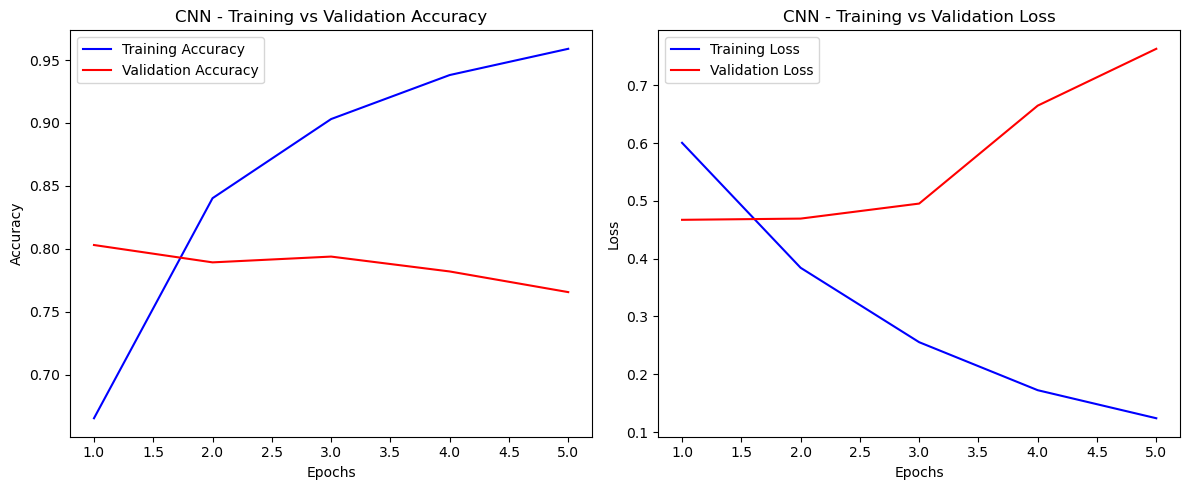

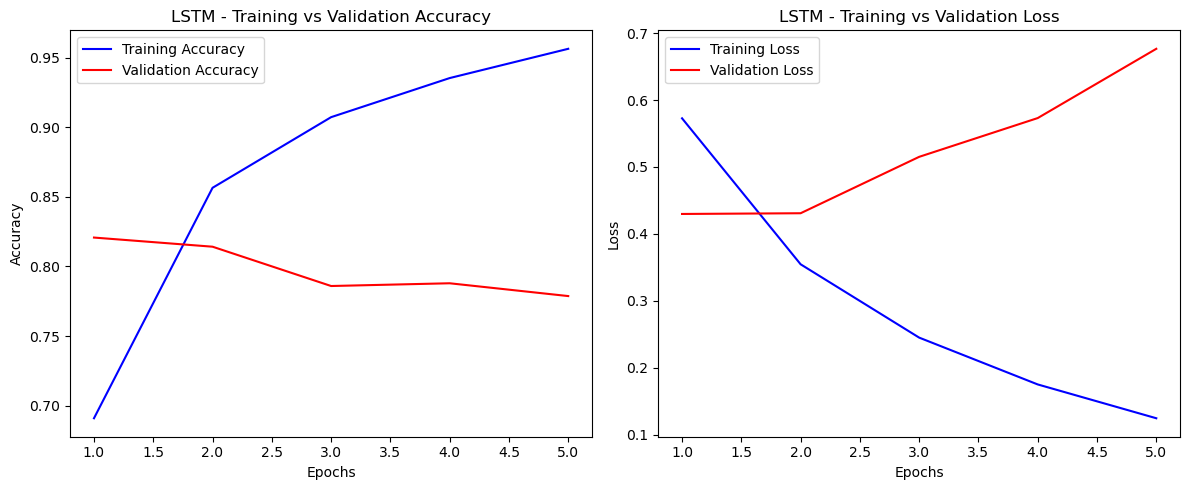

Submission file saved as submission.csv


In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, Conv1D, GlobalMaxPooling1D, 
                                     LSTM, Dense, Dropout, Concatenate, SpatialDropout1D)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Load datasets
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

# Extract text and labels
X, y = train_df["text"].values, train_df["target"].values
X_test = test_df["text"].values

# Tokenization
max_words = 10000
max_length = 100
embedding_dim = 128
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_seq, maxlen=max_length)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# ================================
# CNN Model
# ================================
def build_cnn_model():
    input_layer = Input(shape=(max_length,))
    embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_length)(input_layer)
    x = SpatialDropout1D(0.2)(embedding_layer)
    filter_sizes = [3, 4, 5]
    conv_layers = [GlobalMaxPooling1D()(Conv1D(filters=128, kernel_size=size, activation='relu')(x)) for size in filter_sizes]
    concatenated = Concatenate()(conv_layers)
    x = Dropout(0.5)(concatenated)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# ================================
# LSTM Model
# ================================
def build_lstm_model():
    input_layer = Input(shape=(max_length,))
    embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_length)(input_layer)
    x = LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(embedding_layer)
    x = GlobalMaxPooling1D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# ================================
# Train and Track History
# ================================
models = {
    "CNN": build_cnn_model(),
    "LSTM": build_lstm_model()
}

history_dict = {}  # Store training history
predictions = {}

for name, model in models.items():
    print(f"Training {name}...")
    history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val), verbose=1)
    history_dict[name] = history  # Save history
    predictions[name] = model.predict(X_test_padded).flatten()

# ================================
# Plot Training vs Validation Accuracy & Loss
# ================================
def plot_history(history, model_name):
    epochs = range(1, len(history.history['accuracy']) + 1)
    
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], 'b', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'r', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Training vs Validation Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], 'b', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Training vs Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot graphs for both models
for model_name, history in history_dict.items():
    plot_history(history, model_name)

# ================================
# Ensemble Predictions & Submission
# ================================
final_predictions = np.mean(list(predictions.values()), axis=0)
final_predictions = (final_predictions > 0.5).astype(int)

# Create submission file
submission = sample_submission.copy()
submission["target"] = final_predictions
submission.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")


In [12]:
import matplotlib.pyplot as plt

# Assuming `history` is the training history object from model.fit()
epochs = range(1, len(history.history['accuracy']) + 1)

# Plot Training vs Validation Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], 'b', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'r', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot Training vs Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], 'b', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


NameError: name 'history' is not defined